In [2]:
import yaml

run_path = './runs'

device_list     = ['DDR4', 'DDR5', 'URAM4', 'URAM5', 'FURAM4', 'FURAM5']
org_list        = ['16Gb_x8']
timing_list     = {'DDR4': '3200AA', 'DDR5': '3200AN', 'URAM4': '3200AA', 'URAM5': '3200AN', 'FURAM4': '3200AA', 'FURAM5': '3200AN'}
row_policy_list = ['OpenRowPolicy']

trace_list = ['500.perlbench', '502.gcc'      , '505.mcf'      , '507.cactuBSSN', '508.namd',
              '510.parest'   , '511.povray'   , '519.lbm'      , '520.omnetpp'  , '523.xalancbmk', 
              '525.x264'     , '526.blender'  , '531.deepsjeng', '538.imagick'  , '541.leela',
              '544.nab'      , '549.fotonik3d', '557.xz']

data = {}
for device in device_list:
  for org in org_list:
    for row_policy in row_policy_list:
      for trace in trace_list:
          run_file = f'{device}_{org}_{timing_list[device]}_{row_policy}_{trace}'
          with(open(f'{run_path}/{run_file}.yaml', 'r')) as f:
            data[run_file] = yaml.load(f, Loader=yaml.FullLoader)

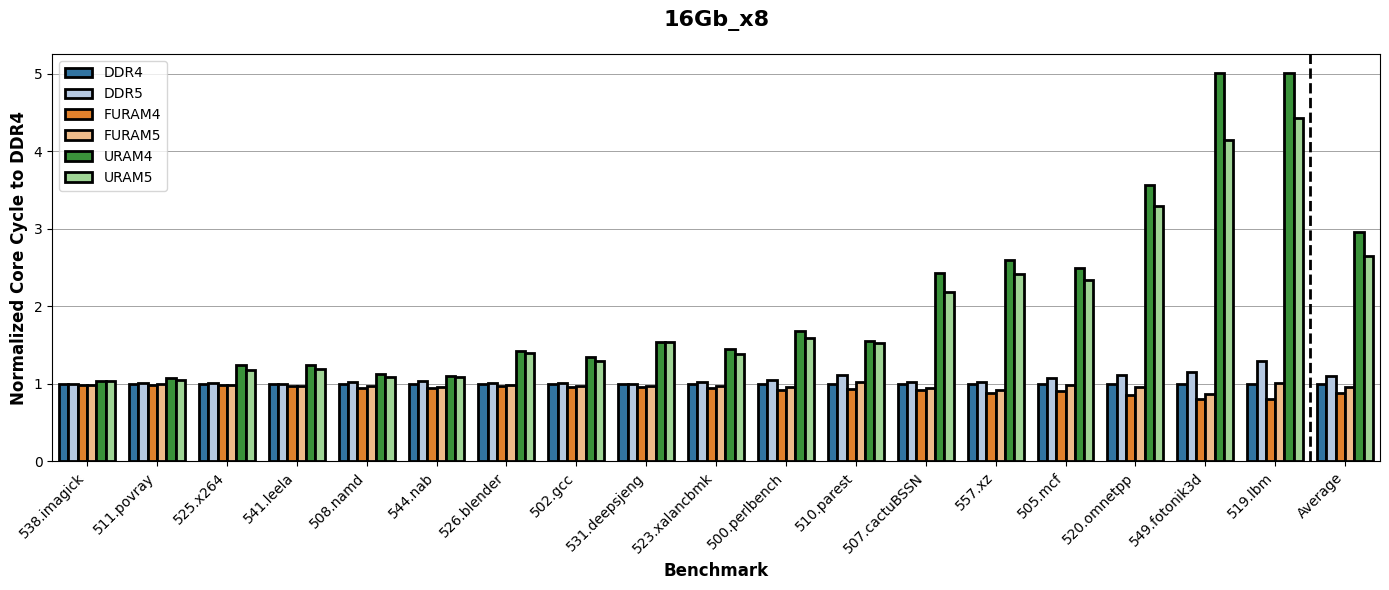

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device_list = ['DDR4', 'DDR5', 'FURAM4', 'FURAM5', 'URAM4', 'URAM5']
# device_list = ['DDR4', 'FURAM4', 'URAM4']
# device_list = ['DDR5', 'FURAM5', 'URAM5']
normalized_to = 'DDR4'
sort_by = 'URAM4'

for org in org_list:
  for row_policy in row_policy_list:

    core_cycle_list = {}
    for device in device_list:
      core_cycle_list[device] = []
      for trace in trace_list:
        core_cycle_list[device].append(data[f'{device}_{org}_{timing_list[device]}_{row_policy}_{trace}']['Frontend']['cycles_recorded_core_0'])

    sorted_data = sorted(zip(trace_list, *[core_cycle_list[device] for device in device_list]), key=lambda x: x[1 + device_list.index(sort_by)])
    benchmarks = []
    core_cycles = []
    devices = []

    for item in sorted_data:
        trace = item[0]
        device_data = item[1:]
        benchmarks.extend([trace] * len(device_list))
        core_cycles.extend([data / device_data[device_list.index(normalized_to)] for data in device_data])
        devices.extend(device_list)

    avg_list = []
    for device in device_list:
      avg_list.append(np.mean(core_cycle_list[device] / np.mean(core_cycle_list[normalized_to])))

    benchmarks.extend(['Average'] * len(device_list))
    core_cycles.extend(avg_list)
    devices.extend(device_list)

    df = pd.DataFrame({
        'Benchmark': benchmarks,
        f'Normalized Core Cycle to {normalized_to}': core_cycles,
        'Device': devices
    })

    plt.figure(figsize=(14, 6))
    barplot = sns.barplot(x='Benchmark', y=f'Normalized Core Cycle to {normalized_to}', hue='Device', 
                          edgecolor='black', linewidth=2, 
                          palette=sns.color_palette('tab20', n_colors=len(device_list)),
                          zorder=2, data=df)

    barplot.legend(loc='upper left')
    barplot.set_xlabel('Benchmark', fontsize=12, fontweight='bold')
    barplot.set_ylabel(f'Normalized Core Cycle to {normalized_to}', fontsize=12, fontweight='bold')
    barplot.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5, color='gray', zorder=0)

    plt.xticks(rotation=45, ha='right')
    plt.title(f'{org}', fontsize=16, fontweight='bold', pad=20)
    plt.axvline(x=len(trace_list) - 0.5, color='black', linestyle='--', linewidth=2)

    plt.tight_layout()
    plt.show()